## P1: Metropolis-Hastings

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def target_density(x):
    return np.sin(x)**2 * np.exp(-np.abs(x))

def metropolis_hastings_algorithm(n_samples, sigma=1.0):
    eps = 1e-10 # For numerical stability
    # Initialize states, set initial state to zero
    x = np.zeros(n_samples+1)
    for i in range(n_samples):
        xs = np.random.normal(loc=x[i], scale=sigma)
        u = np.random.uniform(low=0.0, high=1.0)
        
        # Compute acceptance probability alpha
        alpha = ( target_density(xs) * norm.pdf(x[i], loc=xs, scale=sigma) 
                  / (target_density(x[i]) * norm.pdf(xs, loc=x[i], scale=sigma) + eps) )
        alpha = min(1.0, alpha)
        
        if u <= alpha:
            x[i+1] = xs
        else:
            x[i+1] = x[i]
    return x

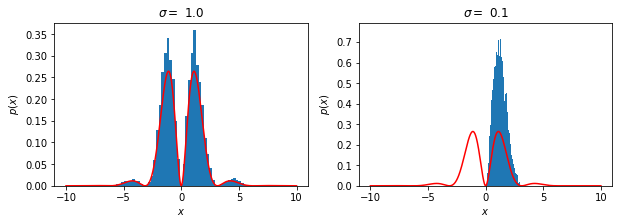

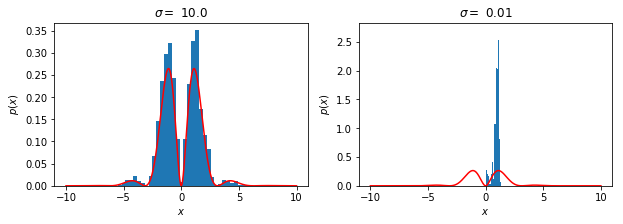

In [55]:
N = 10000
Sigma = [1.0, 0.1]
fig, axs = plt.subplots(1, 2, figsize=(10,3))
array = np.linspace(-10, 10, 1000)

for i, sigma in enumerate(Sigma):
    
    x = metropolis_hastings_algorithm(N, sigma)
    axs[i].hist(x, bins=50, density=True)
    axs[i].plot(array, target_density(array), '-r')
    axs[i].set_xlabel('$x$'); axs[i].set_ylabel('$p(x)$');
    axs[i].set_title("$\sigma =$ {}".format(sigma))

Sigma = [10.0, 0.01]
fig, axs = plt.subplots(1, 2, figsize=(10,3))

for i, sigma in enumerate(Sigma):
    
    x = metropolis_hastings_algorithm(N, sigma)
    axs[i].hist(x, bins=50, density=True)
    axs[i].plot(array, target_density(array), '-r')
    axs[i].set_xlabel('$x$'); axs[i].set_ylabel('$p(x)$');
    axs[i].set_title("$\sigma =$ {}".format(sigma))


## P2: Gibbs Sampling